# **Prepare datasets**

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#membaca data
df = pd.read_csv('train_preprocess.tsv.txt', sep='\t', names=['text', 'label'])
df = df.drop_duplicates()
df_alay = pd.read_csv('new_kamusalay.csv', names=['alay', 'cleaned'], encoding='latin-1')

In [8]:
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [9]:
df.shape

(10933, 2)

In [10]:
df.label.value_counts()

positive    6383
negative    3412
neutral     1138
Name: label, dtype: int64

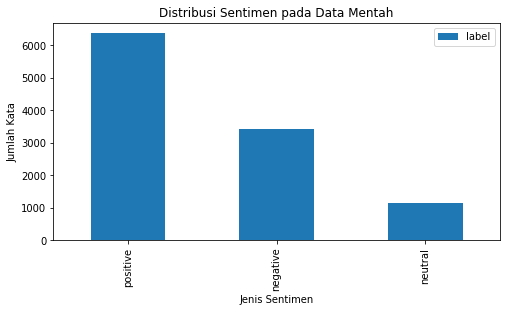

In [11]:
#Cek distribusi data dengan bar plot
df.label.value_counts().plot.bar(figsize = (8, 4))
plt.title('Distribusi Sentimen pada Data Mentah')
plt.xlabel('Jenis Sentimen')
plt.ylabel('Jumlah Kata')
plt.legend()
plt.show()

In [12]:
#menghitung total words
df['total_words']= df.text.apply(lambda sent: len(sent.split()))
df.head()

,text,label,total_words
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,66
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,17
2,lokasi strategis di jalan sumatera bandung . t...,positive,33
3,betapa bahagia nya diri ini saat unboxing pake...,positive,17
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,38


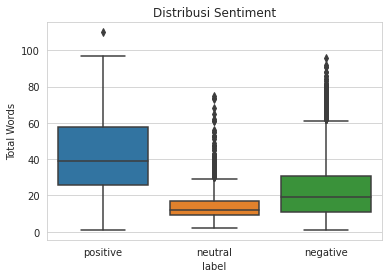

In [13]:
#Cek distribusi data dengan whisker plot
sns.set_style('whitegrid')
sns.boxplot(y = df['total_words'], x = df['label']);
plt.ylabel('Total Words')
plt.title('Distribusi Sentiment')
plt.show()

<function matplotlib.pyplot.legend(*args, **kwargs)>

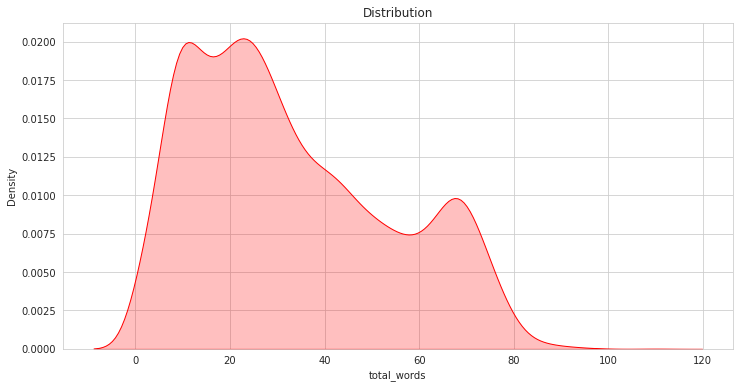

In [14]:
#Cek Distribusi Data

plt.figure(figsize = (12,6))
p1 = sns.kdeplot(df['total_words'],shade = True, color = 'r').set_title('Distribution')
plt.legend

Distribusi data skewness kiri, tidak normal

# **Text Normalization/Cleansing**

In [15]:
import re 

#Fungsi buat cleaning=================================================================================
def lowercase(text):                                #remove lowercase
    return text.lower()

def nonalphanumeric(text):                          #remove nonaplhanumeric
    text = re.sub(r'[^0-9a-zA-Z]+', ' ',text, flags= re.MULTILINE)
    return text

def unnecessary_char(text):
    text = re.sub(r'\W',' ',str(text), flags= re.MULTILINE)                                                 #Remove every special charachters
    text = re.sub(r'rt',' ',text, flags= re.MULTILINE)                                                      #Remove every retweet symbol
    text = re.sub(r'user',' ',text, flags= re.MULTILINE)                                                    #Remove every username
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text, flags= re.MULTILINE)      #Remove every URL
    text = re.sub(r'\s+', ' ', text, flags= re.MULTILINE)                                                   #Subtitute multi spaces with single space
    return text

format_alay = dict(zip(df_alay['alay'], df_alay['cleaned']))                                                #formating kamusalay
def cleaning_alay(text):                                                                                    #Remove 'alay' words
    split_text_alay = text.split()
    text_alay = [format_alay.get(x,x) for x in split_text_alay]
    cleaned_alay = ' '.join(text_alay)
    return cleaned_alay

#Function for text cleansing
def cleaning (text):
    text = lowercase(text)
    text = nonalphanumeric(text)
    text = unnecessary_char(text)
    text = cleaning_alay(text)
    return text

In [16]:
df['text_clean'] = df.text.apply(cleaning)

In [17]:
df.head()

,text,label,total_words,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,66,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,17,mohon ulama lurus dan k212 mmbri hujjah pak ai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,33,lokasi strategis di jalan sumatra bandung temp...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,17,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,38,aduh jadi mahasiswa jangan sombong dong kasih ...


Sortir data dan label berdasarkan sentimen

In [18]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [19]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


# **Feature Extraction**

In [20]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [21]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


# **Prepare train & test datasets/Splitting Dataset**

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [22]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# **Training**

In [23]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [24]:
embed_dim = 100

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
# model.add(layers.Conv1D(128, 5, activation='relu'))
# model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 conv1d (Conv1D)             (None, 92, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 10,065,451
Trainable params: 10,065,451
Non-trainable params: 0
____________________________________________

# Evaluation

## Confussion Matrix, Accuracy, F1, Recall

In [25]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 4ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       668
           1       0.82      0.79      0.80       231
           2       0.95      0.90      0.92      1288

    accuracy                           0.88      2187
   macro avg       0.85      0.86      0.85      2187
weighted avg       0.89      0.88      0.88      2187



## Cross Validation

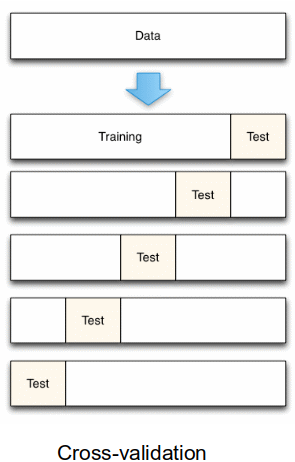

In [26]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=maxlen))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 0s 2ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       668
           1       0.77      0.85      0.80       231
           2       0.95      0.89      0.92      1288

    accuracy                           0.88      2187
   macro avg       0.84      0.87      0.85      2187
weighted avg       0.89      0.88      0.88      2187

69/69 [==============================] - 0s 2ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       668
           1       0.80      0.81      0.81       231
           2       0.92      0.94      0.93      1288

    accuracy                           0.89      2187
   macro avg       0.86      0.86      0.86      2187
weighted avg       0.89      0.89      0.89      2187

69/69 [==============================] - 0s 2ms/step
Training ke- 3
              precision    recall 

Hasilnya nilai rata-rata accuracy pada angka 0.88. 

## Visualization

**Overfitting**

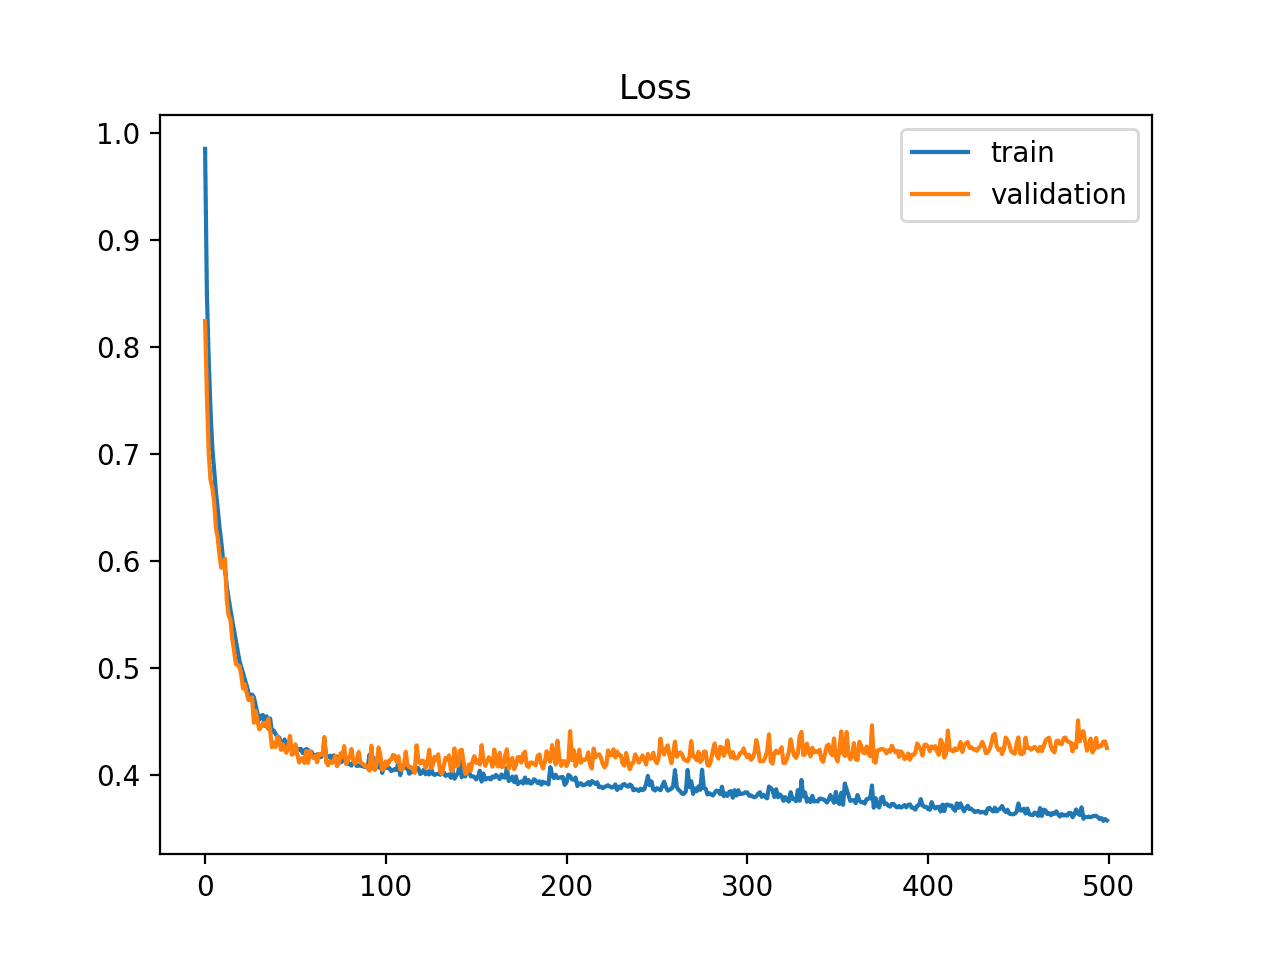

**Underfitting**
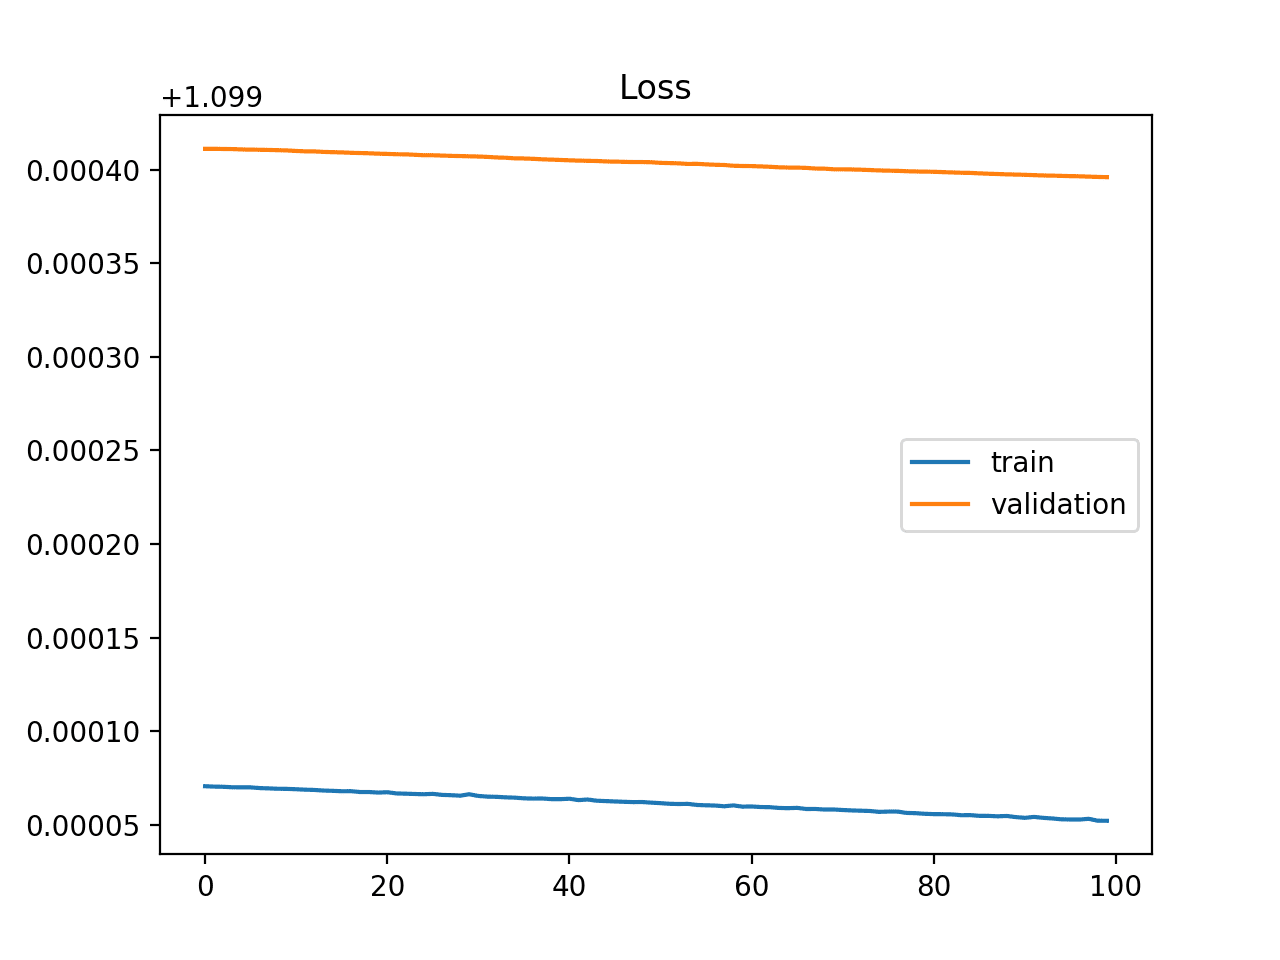

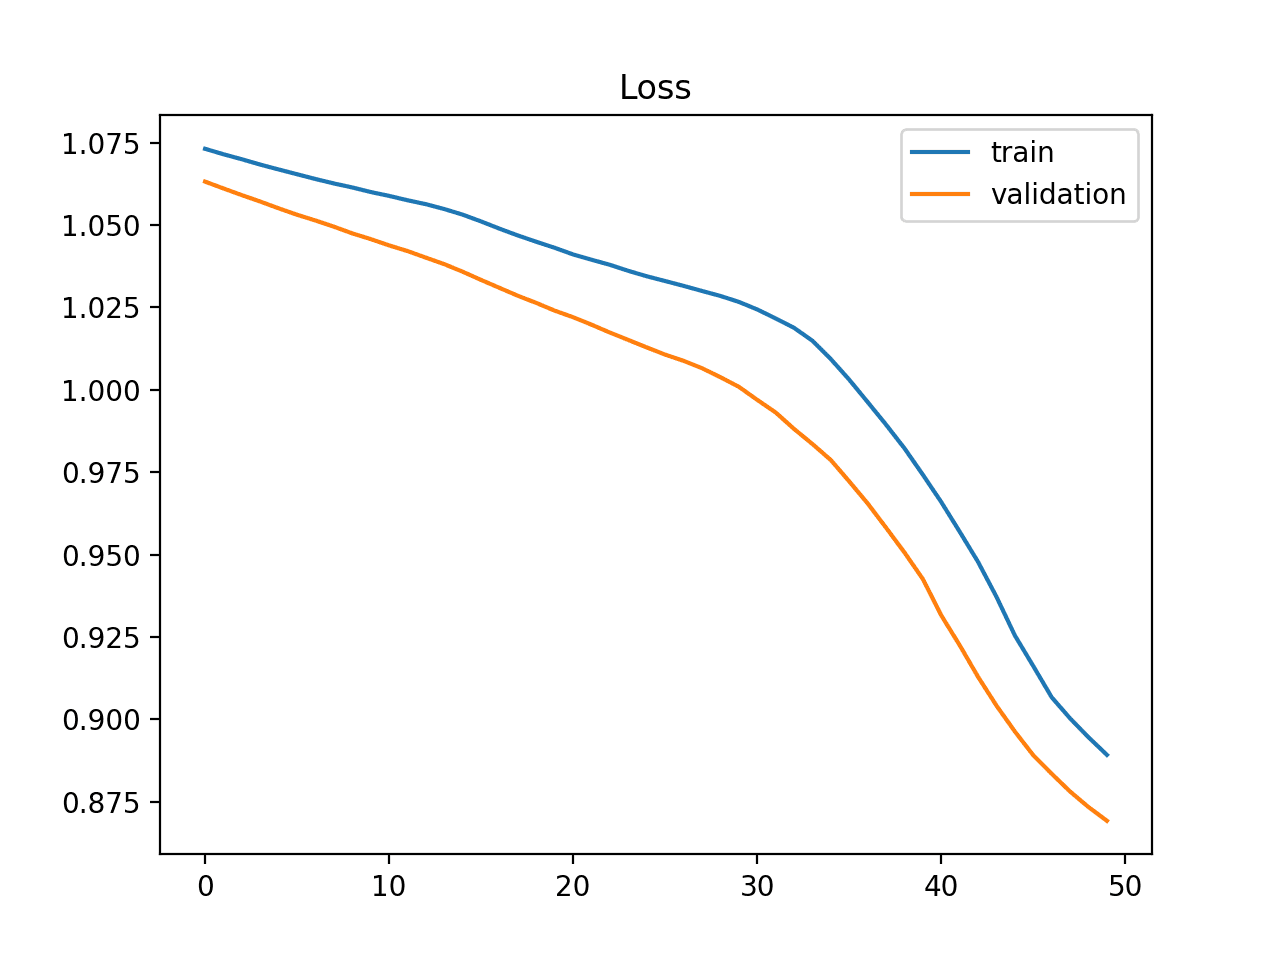

**Good Fit**

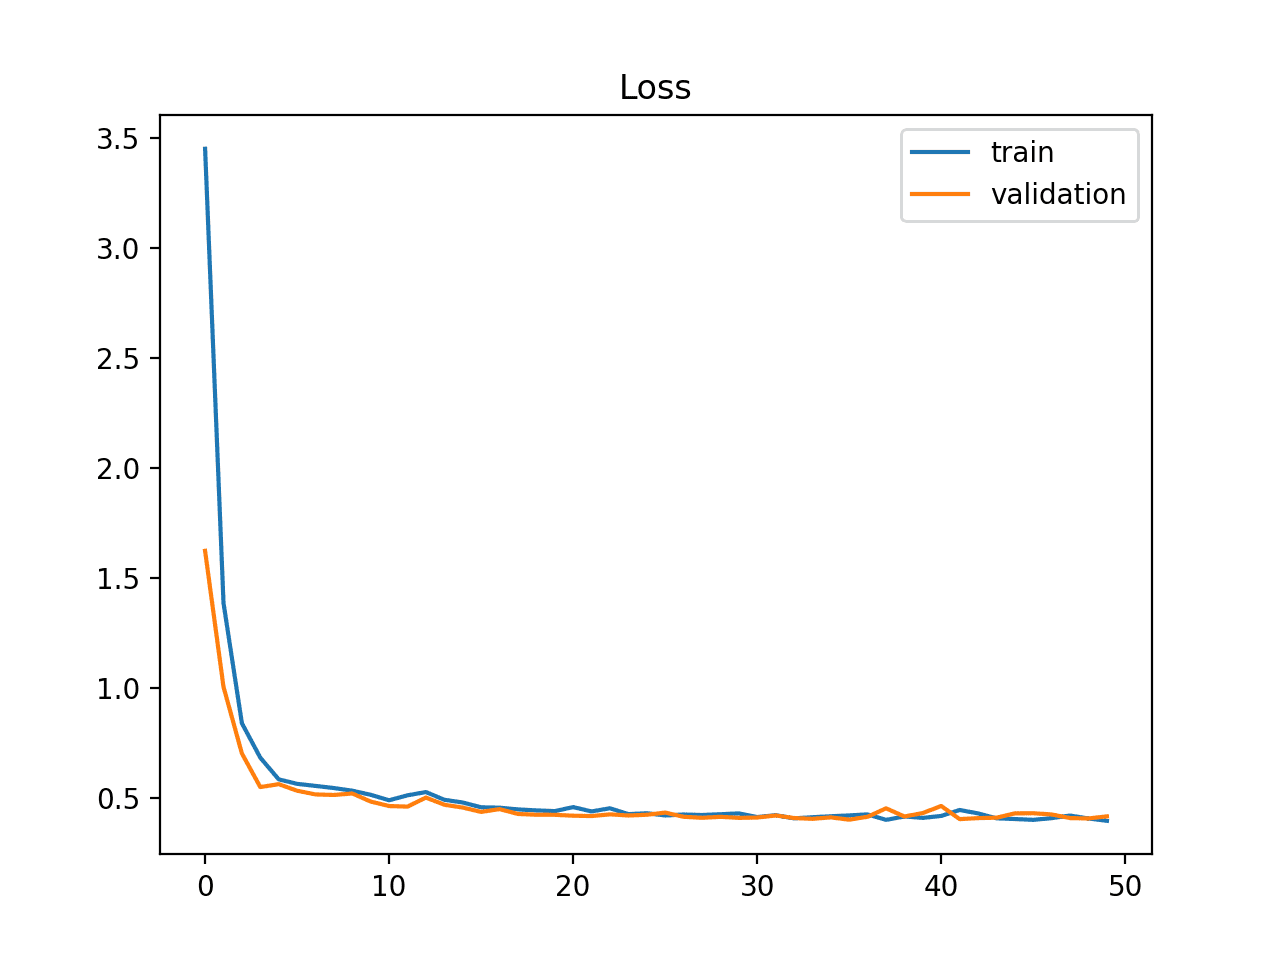

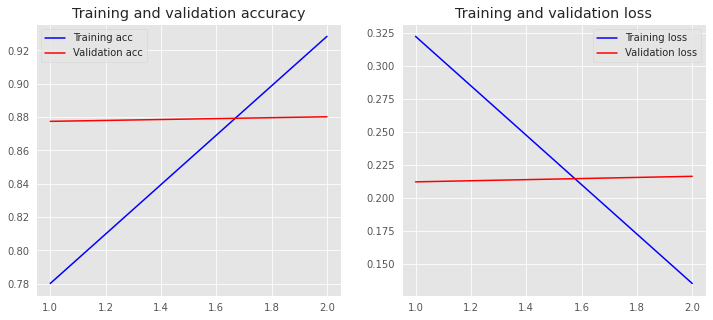

In [27]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [28]:
model.save('model.h5')
print("Model has created!")

Model has created!


# Predict

In [29]:
import re 
from keras.models import load_model

input_text = """
kamu gila sekali.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 249ms/step
Text:   kamu gila sekali  
Sentiment:  negative
